# Notebook to QC Section 2.3 that relates diffusive fluxes through the lateral boundaries of control volume. Unless numerical diffusion is large, the below analysis should close to nill.

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree()

In [2]:
# Open the parent models at hourly output
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

In [4]:
def calc_kh(ds):
    '''
Calculates the horizontal eddy diffusivity scaled to 
the grid size
    '''
    dA = ds.dA
    dA_max = (np.sqrt(dA)).max()
    kh_0 = 1.0 #m^2/s
    kh = (kh_0/dA_max)*(np.sqrt(dA))
    return kh

def horz_sprime2_diffusion(ds, etaslice, xislice, grid, k_h):
    '''
Calculates the volume-integrated horizontal volume-mean salinity variance 
diffusive boundary flux.
    '''
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(dim = ['eta_rho', 's_rho', 'xi_rho'])
    salt = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice)
    sbar = (1/V)*(salt*dV).sum(dim = ['eta_rho', 'xi_rho','s_rho'])
    sprime = ds.salt-sbar
    sprime2 = sprime**2
    sprime2.name = 'sprime2'
    
    dsaltprime2dxi, dsaltprime2deta = xroms.hgrad(sprime2, grid)
    #Interpolate to the rho points
    dsprime2dx_rho = grid.interp(dsaltprime2dxi, 'Z')
    dsprime2dy_rho = grid.interp(dsaltprime2deta, 'Z')

    k_h_u = grid.interp(k_h, 'X')
    k_h_v = grid.interp(k_h, 'Y')

    dxdz = (ds.dx_v*ds.dz_v)
    dydz = (ds.dy_u*ds.dz_u)

    hdiffusion_u = (k_h_u*dsprime2dx_rho*dydz).isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    hdiffusion_v = (k_h_v*dsprime2dy_rho*dxdz).isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    hdiffW = (hdiffusion_u).isel(xi_u = 0) #West
    hdiffE = (hdiffusion_u).isel(xi_u = -1) #East
    hdiffN = (hdiffusion_v).isel(eta_v = -1) #North
    hdiffS = (hdiffusion_v).isel(eta_v = 0) #South
    
    #Name individual components to merge into a dataset
    hdiffW.name = 'hdiffW'
    hdiffE.name = 'hdiffE'
    hdiffN.name = 'hdiffN'
    hdiffS.name = 'hdiffS'

    hdiffds = xr.merge([hdiffW, hdiffE, hdiffN, hdiffS], compat='override')
    
    sprime2_horz_diff = -(hdiffds.hdiffW.sum(['eta_rho', 's_rho'])-hdiffds.hdiffE.sum(['eta_rho', 's_rho']) \
                        +hdiffds.hdiffS.sum(['xi_rho', 's_rho'])-hdiffds.hdiffN.sum(['xi_rho', 's_rho']))
    return sprime2_horz_diff

def horz_s2_diffusion(ds, etaslice, xislice, grid, k_h):   
        '''
Calculates the volume-integrated horizontal salt squared 
diffusive boundary flux.
    '''
    dsalt2dxi, dsalt2deta = xroms.hgrad(ds.salt**2, grid)
    #Interpolate to the rho points
    dsalt2dx_rho = grid.interp(dsalt2dxi, 'Z')
    dsalt2dy_rho = grid.interp(dsalt2deta, 'Z')

    k_h_u = grid.interp(k_h, 'X')
    k_h_v = grid.interp(k_h, 'Y')

    dxdz = (ds.dx_v*ds.dz_v)
    dydz = (ds.dy_u*ds.dz_u)

    hdiffusion_u = (k_h_u*dsalt2dx_rho*dydz).isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    hdiffusion_v = (k_h_v*dsalt2dy_rho*dxdz).isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    hdiffW = (hdiffusion_u).isel(xi_u = 0) #West
    hdiffE = (hdiffusion_u).isel(xi_u = -1) #East
    hdiffN = (hdiffusion_v).isel(eta_v = -1) #North
    hdiffS = (hdiffusion_v).isel(eta_v = 0) #South
    
    #Name individual components to merge into a dataset
    hdiffW.name = 'hdiffW'
    hdiffE.name = 'hdiffE'
    hdiffN.name = 'hdiffN'
    hdiffS.name = 'hdiffS'

    hdiffds = xr.merge([hdiffW, hdiffE, hdiffN, hdiffS], compat='override')
    
    s2_horz_diff = -(hdiffds.hdiffW.sum(['eta_rho', 's_rho'])-hdiffds.hdiffE.sum(['eta_rho', 's_rho']) \
                        +hdiffds.hdiffS.sum(['xi_rho', 's_rho'])-hdiffds.hdiffN.sum(['xi_rho', 's_rho']))
    return s2_horz_diff

def horz_sprimesbar_diffusion(ds, etaslice, xislice, grid, k_h):
    '''
Calculates the volume-integrated horizontal cross
diffusive boundary flux.
    '''
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(dim = ['eta_rho', 's_rho', 'xi_rho'])
    salt = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice)
    sbar = (1/V)*(salt*dV).sum(dim = ['eta_rho', 'xi_rho','s_rho'])
    sprime = ds.salt-sbar
    sprime.name = 'sprime'
    
    dsaltprimedxi, dsaltprimedeta = xroms.hgrad(sprime, grid)
    #Interpolate to the rho points
    dsprimedx_rho = grid.interp(dsaltprimedxi, 'Z')
    dsprimedy_rho = grid.interp(dsaltprimedeta, 'Z')

    k_h_u = grid.interp(k_h, 'X')
    k_h_v = grid.interp(k_h, 'Y')

    dxdz = (ds.dx_v*ds.dz_v)
    dydz = (ds.dy_u*ds.dz_u)

    hdiffusion_u = (k_h_u*dsprimedx_rho*dydz).isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    hdiffusion_v = (k_h_v*dsprimedy_rho*dxdz).isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    hdiffW = (hdiffusion_u).isel(xi_u = 0) #West
    hdiffE = (hdiffusion_u).isel(xi_u = -1) #East
    hdiffN = (hdiffusion_v).isel(eta_v = -1) #North
    hdiffS = (hdiffusion_v).isel(eta_v = 0) #South
    
    #Name individual components to merge into a dataset
    hdiffW.name = 'hdiffW'
    hdiffE.name = 'hdiffE'
    hdiffN.name = 'hdiffN'
    hdiffS.name = 'hdiffS'

    hdiffds = xr.merge([hdiffW, hdiffE, hdiffN, hdiffS], compat='override')
    
    sbarsprime_horz_diff = 2*sbar*(-(hdiffds.hdiffW.sum(['eta_rho', 's_rho'])-hdiffds.hdiffE.sum(['eta_rho', 's_rho']) \
                        +hdiffds.hdiffS.sum(['xi_rho', 's_rho'])-hdiffds.hdiffN.sum(['xi_rho', 's_rho'])))
    return sbarsprime_horz_diff
#----------- 
#Run the functions 
kh_parent = calc_kh(ds_avg)#Horizontal eddy diffusivity

#s^2 diffusive flux
s2_horz_diff_parent = horz_s2_diffusion(ds_avg, etaslice, xislice, grid_avg, kh_parent)

#s^'^2 diffusive flux
sprime2_horz_diff_parent = horz_sprime2_diffusion(ds_avg, etaslice, xislice, grid_avg, kh_parent)

#2sbars' difffusive flux
sbarsprime_horz_diff = horz_sprimesbar_diffusion(ds_avg, etaslice, xislice, grid_avg, kh_parent)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 61)

In [ ]:
s2 = s2_horz_diff_parent[:100].load()
sprime2 = sprime2_horz_diff_parent[:100].load()
cross = sbarsprime_horz_diff[:100].load()

In [ ]:
s2.plot()
sprime2.plot()
cross.plot()

Text(0, 0.5, '[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')

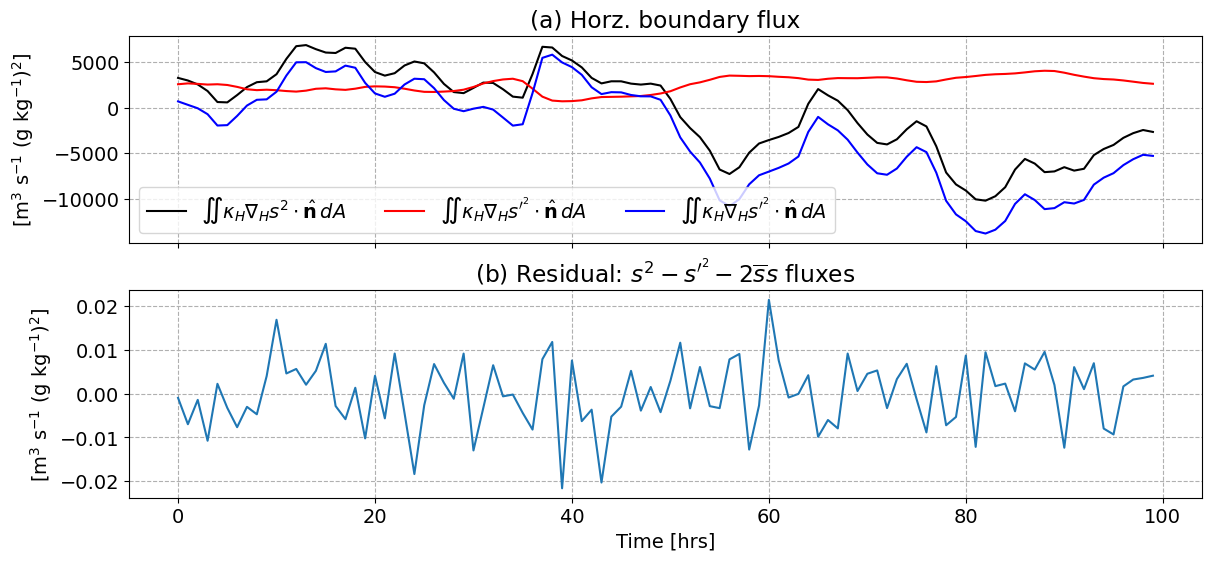

In [22]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(2,1, figsize = (12,2.75*2), constrained_layout = True, sharey = False)

ax[0].plot(s2, lw = 1.5, c = 'k', label = r'$\iint \kappa_H \nabla_H s^2 \cdot \hat{\mathbf{n}} \, dA$')
ax[0].plot(sprime2, lw = 1.5, c = 'r', label = r'$\iint \kappa_H \nabla_H s^{\prime^2} \cdot \hat{\mathbf{n}} \, dA$')
ax[0].plot(cross, lw = 1.5, c = 'b', label = r'$2 \overline{s} \iint \kappa_H \nabla_H s^{\prime} \cdot \hat{\mathbf{n}} \, dA$')
ax[0].set_title('(a) Horz. boundary flux')
ax[0].legend(loc = 'lower left', ncol = 3)
ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].grid(linestyle = '--')
ax[0].set_xlabel('')
ax[0].set_xticklabels('')

ax[1].plot(s2-sprime2-cross, lw = 1.5)
ax[1].set_title('(b) Residual: $s^2-s^{\prime^2}-2\overline{s}s$ fluxes')
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('Time [hrs]')
# ax[1].set_xticklabels('')
ax[1].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
# plt.savefig('figures/editor_response.jpg', dpi = 300, bbox_inches='tight')

# Perfect - this looks correct. Now compute that cross term for the entire study period. Turn into a script at a later time 

In [25]:
dates = np.arange('2010-06-03', '2010-07-14', dtype = 'datetime64[D]') 
for d in range(len(dates)):
    sbarsprime_horz_diff_sel = sbarsprime_horz_diff.sel(ocean_time = str(dates[d]))
    sbarsprime_horz_diff_sel.attrs = ''
    path = '/d2/home/dylan/JAMES/revised_submission/horz_terms/sbarsprime_hdiffusion_60min_%s.nc' %d
    sbarsprime_horz_diff_sel.name = 'sbarsprime_diff_flux'
    sbarsprime_horz_diff_sel.to_netcdf(path, mode = 'w')

# Now open output for all 3 diffusive fluxes for entire study period and plot them. This will be useful for the editor's comments as well. 

In [47]:
#Horizontal diffusion
s2_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/s2_horz/s2_horz_diff_parent_*.nc').s2_diff_flux
sprime2_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/sprime2_horz/sprime2_horz_diff_parent_*.nc').s2_diff_flux
sbarsprime_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/sbarsprime_hdiffusion_60min_*.nc').sbarsprime_diff_flux

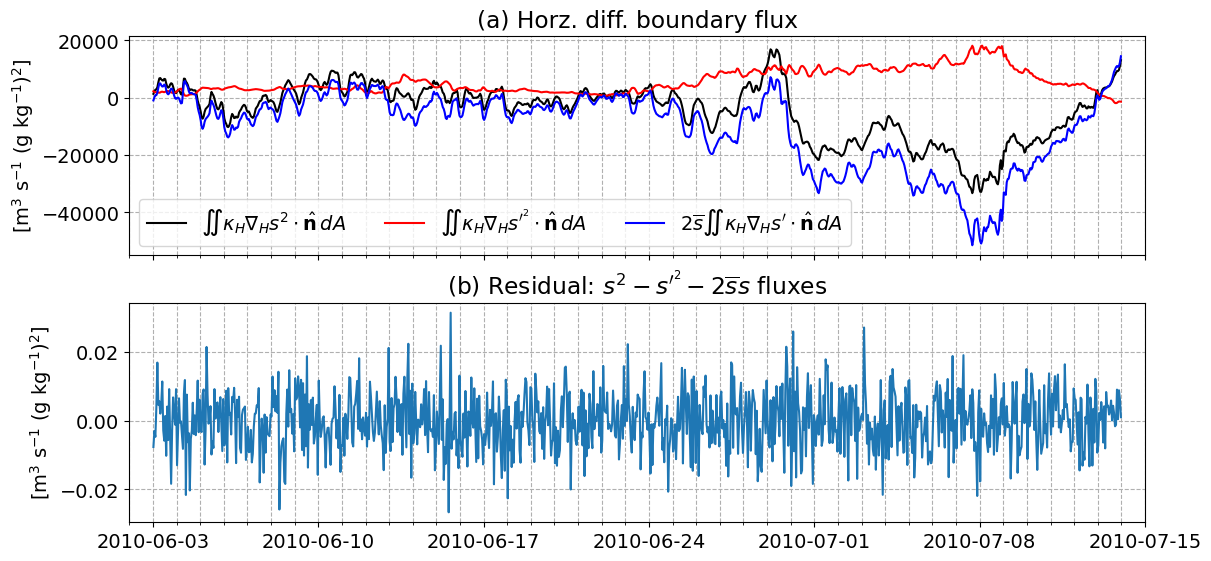

In [48]:
plt.rcParams.update({'font.size': 14})
time = sbarsprime_diff_flux.ocean_time.values

myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]


fig, ax = plt.subplots(2,1, figsize = (12,2.75*2), constrained_layout = True, sharey = False)

ax[0].plot(time, s2_diff_flux, lw = 1.5, c = 'k', label = r'$\iint \kappa_H \nabla_H s^2 \cdot \hat{\mathbf{n}} \, dA$')
ax[0].plot(time, sprime2_diff_flux, lw = 1.5, c = 'r', label = r'$\iint \kappa_H \nabla_H s^{\prime^2} \cdot \hat{\mathbf{n}} \, dA$')
ax[0].plot(time, sbarsprime_diff_flux, lw = 1.5, c = 'b', label = r'$2 \overline{s} \iint \kappa_H \nabla_H s^{\prime} \cdot \hat{\mathbf{n}} \, dA$')
ax[0].set_title('(a) Horz. diff. boundary flux')
ax[0].legend(loc = 'lower left', ncol = 3)
ax[0].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].set_xticks(ticks = dates)
ax[0].grid(linestyle = '--')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])


ax[1].plot(time, s2_diff_flux-sprime2_diff_flux-sbarsprime_diff_flux, lw = 1.5)
ax[1].set_title('(b) Residual: $s^2-s^{\prime^2}-2\overline{s}s$ fluxes')
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('Time [hrs]')
ax[1].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[1].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[1].set_xticks(ticks = dates)
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('')
ax[1].set_xticklabels([])
ax[1].xaxis.set_major_formatter(myFmt)

for i in range(2):
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
    
plt.savefig('figures/QC_diffusion.jpg', dpi = 300, bbox_inches='tight')

# Great! Small residual as expected, which confirms the math in Section 2.3 is right.